# Pose Detection

In [69]:
from __future__ import division
import argparse, time, logging, os, math, tqdm, cv2
import uuid

import boto3
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
import pandas as pd
import gluoncv as gcv
gcv.utils.check_version('0.6.0')
from gluoncv import data
from gluoncv.data import mscoco
from gluoncv.model_zoo import get_model
from gluoncv.data.transforms.pose import detector_to_alpha_pose, heatmap_to_coord_alpha_pose
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord
from gluoncv.utils.viz import cv_plot_image, cv_plot_keypoints

1. [Set Up](#1.-Set-Up)
2. [Select a pre-trained model](#2.-Select-a-pre-trained-model)
3. [Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model)
    * [Retrieve Artifacts & Deploy an Endpoint](#3.1.-Retrieve-Artifacts-&-Deploy-an-Endpoint)
    * [Download example images for inference](#3.2.-Download-example-images-for-inference)
    * [Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response)
    * [Clean up the endpoint](#3.4.-Clean-up-the-endpoint)
4. [Fine-tune the pre-trained model on a custom dataset](#4.-Fine-tune-the-pre-trained-model-on-a-custome-dataset)
    * [Retrieve Training artifacts](#4.1.-Retrieve-Training-artifacts)
    * [Set Training parameters](#4.2.-Set-Training-parameters)
    * [Train with Automatic Model Tuning (HPO)](#AMT)
    * [Start Training](#4.4.-Start-Training)
    * [Deploy & run Inference on the fine-tuned model](#4.5.-Deploy-&-run-Inference-on-the-fine-tuned-model)
    * [Incrementally train the fine-tuned model](#4.6.-Incrementally-train-the-fine-tuned-model)

## 1. Set Up
***
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.
***

In [38]:
import gluoncv


In [39]:
gluoncv.utils.check_version('0.6.0')

In [40]:
import sagemaker, boto3, json
import numpy as np
import cv2
import mxnet as mx
import math
import datetime
from sagemaker.session import Session
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

Some Useful functions

## 2. Select a pre-trained model
***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).
***

***
Select a different Sagemaker pre-trained model. Here, we download the model_manifest file from the Built-In Algorithms s3 bucket, filter-out all the Image Classification models and select a model for inference.
***

In [70]:
#pose_model = 'alpha_pose_resnet101_v1b_coco'
pose_model = 'simple_pose_resnet18_v1b'

In [71]:
pose_model_settings = {'alpha_pose_resnet101_v1b_coco':{'Size':512},
                       'simple_pose_resnet18_v1b':{'Size':256}}

In [72]:
people_detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_detector = model_zoo.get_model(pose_model, pretrained=True)

Because the yolo_mobilenet1.0_coco pre-trained model is trained to detect many types of objects in addition to people, the code below narrows down the detection criteria to just people so that the model runs faster.

In [73]:
people_detector.reset_class(["person"], reuse_weights=['person'])

## Rerun the blow code until Chair detection to test posture_analysis.py

### Pre-process an image for detector, and make inference

The following code shows how to use the people detector to detect people in the frame. The outputs of the people detector are the class_IDs (just “person” in this use case because we’ve limited the model’s search scope), the confidence scores, and a bounding box around each person detected in the frame. 

This function returns two results. The first is a NDArray with shape (batch_size, RGB_channels, height, width). It can be fed into the model directly. The second one contains the images in numpy format to easy to be plotted. Since we only loaded a single image, the first dimension of x is 1.

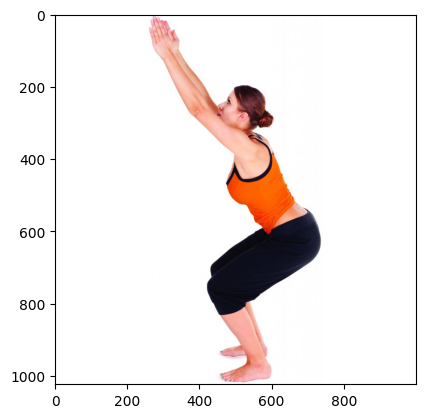

In [74]:
frame = mpimg.imread('images/Chairpose2.jpg')
frame = cv2.flip(frame,1)
%matplotlib inline
plt.imshow(frame)
plt.show()

In [75]:
img = mx.nd.array(frame)
x, img = data.transforms.presets.ssd.transform_test(img, short=pose_model_settings[pose_model]['Size'])

Let's detect people

In [76]:
class_IDs, scores, bounding_boxs = people_detector(x)

### Process tensor from detector to keypoint network

For a Simple Pose network, it expects the input has the size 256x192, and the human is centered. We crop the bounding boxed area for each human, and resize it to 256x192, then finally normalize it.

In order to make sure the bounding box has included the entire person, we usually slightly upscale the box size.



In [77]:
if pose_model is 'alpha_pose_resnet101_v1b_coco':
    pose_input, upscale_bbox = detector_to_alpha_pose(img, class_IDs, scores, bounding_boxs)
if pose_model is 'simple_pose_resnet18_v1b':
    pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)


### Predict with a Simple Pose network

Now we can make prediction.

A Simple Pose network predicts the heatmap for each joint (i.e. keypoint). After the inference we search for the highest value in the heatmap and map it to the coordinates on the original image.

In [79]:
predicted_heatmap = pose_detector(pose_input)
if pose_model is 'alpha_pose_resnet101_v1b_coco':
    pred_coords, confidence = heatmap_to_coord_alpha_pose(predicted_heatmap, upscale_bbox)
if pose_model is 'simple_pose_resnet18_v1b':
    pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)


|### Pre-process an image for detector, and make inference¶
Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a custom dataset. For this example, that means on an input image, predicting the class label from one of the 1000 classes of the ImageNet dataset. 

**Bounding Box**: [x,y, width, height]


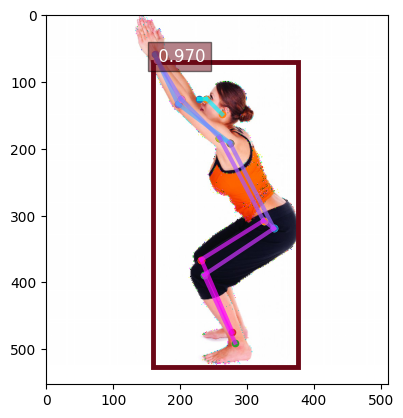

In [65]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs,scores, box_thresh=0.2, keypoint_thresh=0.2)
plt.show(ax)

In [80]:
confidence


[[[0.78233117]
  [0.83383834]
  [0.6693105 ]
  [0.90259147]
  [0.39746052]
  [0.7413373 ]
  [0.5397878 ]
  [0.800673  ]
  [0.21353363]
  [0.84190744]
  [0.23166847]
  [0.70333636]
  [0.5451485 ]
  [0.82697374]
  [0.69715434]
  [0.70989233]
  [0.4898322 ]]]
<NDArray 1x17x1 @cpu(0)>

### Testing the posuter analysis module

In [66]:
import posture_analysis
import importlib
import json
from posture_analysis import PostureAnalysis
importlib.reload(posture_analysis)
postureAnalysis = posture_analysis.PostureAnalysis()

client = boto3.client('dynamodb')

iot_topic = "xxxxx"
session = None
client = "xxx"
pose = "chair"

In [67]:
boole, boole_list, myjson = postureAnalysis.create_json(pred_coords, confidence, bounding_boxs, scores, session, pose)

In [51]:
boole_list

[{'Right Upper Arm': True}]

In [52]:
boole

False

In [53]:
json.loads(myjson)

[{'Timestamp': '2022-11-20 14:43:15',
  'Bodyparts': {'Right Lower Arm': {'Angle': 43.93467486683439,
    'Conf': 0.5495809914029905},
   'Left Lower Arm': {'Angle': 35.50222570808573, 'Conf': 0.2913709002526197},
   'Right Upper Arm': {'Angle': 59.58313951551694, 'Conf': 0.6410772656838617},
   'Left Upper Arm': {'Angle': 12.451096623232484,
    'Conf': 0.045596609008491606},
   'Right Thigh': {'Angle': -35.04438073080377, 'Conf': 0.4946820325836967},
   'Left Thigh': {'Angle': -31.443462893442582, 'Conf': 0.2971868781766176},
   'Hips': {'Angle': 0.0, 'Conf': 0.2971868781766176}},
  'Deviations': {'Right Upper Arm': {'Diff': 0.4168604844830597}},
  'Direction': '',
  'Facing': 'Left Facing'}]

In [ ]:
test = {json.loads(myjson)
}

## Let's detect whellchair

In [33]:
chair_detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
chair_detector.reset_class(["bicycle"], reuse_weights=['bicycle'])

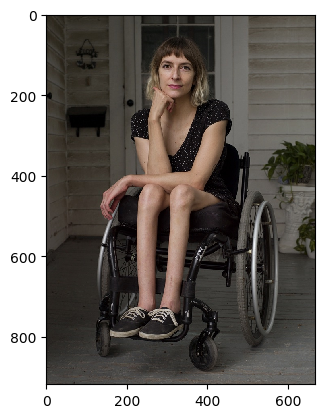

In [34]:
frame_chair = mpimg.imread('wheelchair6.jpg')
%matplotlib inline
plt.imshow(frame_chair)
plt.show()

In [35]:
def find_wheelchair(chair_detector, x_chair, img_chair):
    class_IDs_chair, scores_chair, bounding_boxs_chair = chair_detector(x_chair)
    chair_score = max(scores_chair[0].reshape(-1))
    chair_detected = False
    confidence_chair = None
    if chair_score != -1 and chair_score > 0.01:
        chair_detected = True
    return bounding_boxs_chair, chair_detected

In [36]:
img_chair = mx.nd.array(frame_chair)
x_chair, img_chair = data.transforms.presets.ssd.transform_test(img_chair, short=256)

In [37]:
bounding_boxs_chair, chair_detected = find_wheelchair(chair_detector,x_chair, img_chair)

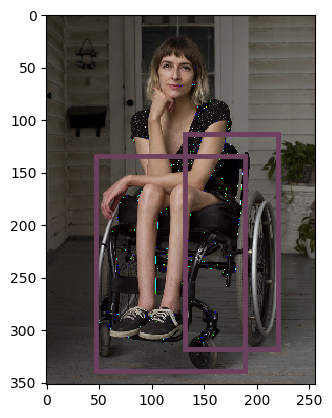

In [38]:
ax = utils.viz.plot_bbox(img_chair, bounding_boxs_chair[0])
plt.show(ax)